<a href="https://colab.research.google.com/github/statscol/energ_cons_test/blob/master/colab_notebook_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simulación Manar

Plan piloto CaribeSol

In [1]:
import random
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import scipy 
import os
import warnings
%matplotlib inline

In [3]:
data=pd.read_csv("DBCaribeSol.txt",sep="|",decimal=",")
print(data)

,Servicio,Id_DesServicio,Id_Categoria,Id_SubCategoria,Localidad,Urbanidad1,Direccion,Estdcorte,UnidadesAnt1,ValorAnterior
0,129079751,701 - ENERGÍA MDO REGULADO,1 - RESIDENCIAL,2 - ESTRATO 2,MEDELLÍN,NO,RURAL_119004850000000000_119004850000000000,1 - Conexion,1647.0,201361.96
1,110413914,701 - ENERGÍA MDO REGULADO,1 - RESIDENCIAL,4 - ESTRATO 4,MEDELLÍN,SI,CL 8 CR 84 F -25 (INTERIOR 1419 ),1 - Conexion,144.0,41137.92
2,90000290,701 - ENERGÍA MDO REGULADO,1 - RESIDENCIAL,5 - ESTRATO 5,MEDELLÍN,SI,CL 7 CR 80 -100 (INTERIOR 509 ),1 - Conexion,400.0,130118.08
3,90000407,701 - ENERGÍA MDO REGULADO,1 - RESIDENCIAL,5 - ESTRATO 5,MEDELLÍN,SI,CL 7 CR 80 -100 (INTERIOR 407 ),1 - Conexion,412.0,134227.07
4,90002377,701 - ENERGÍA MDO REGULADO,1 - RESIDENCIAL,2 - ESTRATO 2,MEDELLÍN,SI,CL 2 B CR 81 A -20 (INTERIOR 301 ),1 - Conexion,256.0,36761.30
...,...,...,...,...,...,...,...,...,...,...
9995,92255463,701 - ENERGÍA MDO REGULADO,1 - RESIDENCIAL,4 - ESTRATO 4,BELLO,SI,CL 23 CR 55 -83,1 - Conexion,652.0,186263.36
9996,92258762,701 - ENERGÍA MDO REGULADO,1 - RESIDENCIAL,3 - ESTRATO 3,BELLO,SI,CL 27 A CR 58 BB -99,1 - Conexion,238.0,57388.46
9997,92262422,701 - ENERGÍA MDO REGULADO,1 - RESIDENCIAL,3 - ESTRATO 3,BELLO,SI,CL 27 CR 58 BB -28,1 - Conexion,250.0,60282.00
9998,92259154,701 - ENERGÍA MDO REGULADO,1 - RESIDENCIAL,3 - ESTRATO 3,BELLO,SI,CL 27 A CR 58 BB -16,1 - Conexion,264.0,64962.72


## Analizar Distribuciones de los Datos

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


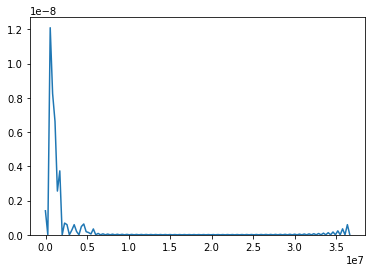

In [4]:
import seaborn as sns
sns.distplot(data.ValorAnterior.values,hist=False)

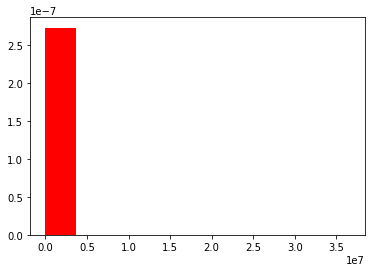

In [5]:
plt.hist(data.ValorAnterior.values, density=True, facecolor='r');

Beta Distribution

μ=E[X]=α/α+β
 
using the identity Γ(t+1)=tΓ(t). Similarly
var=αβ/(α+β)**2(α+β+1)

In [ ]:

variable = data.ValorAnterior.values

mean, varianza  = scipy.stats.distributions.norm.fit(variable)

from sympy import *
a, b = symbols('a b',real=True)

m=Eq(a/(a+b),mean)
v=Eq(a*b*(a+b)**-2 *(a+b+1)**-1,varianza)
sol = solve((m, v),(a, b))
sol[0]

(-2031228234.86304, 2031206523.63916)

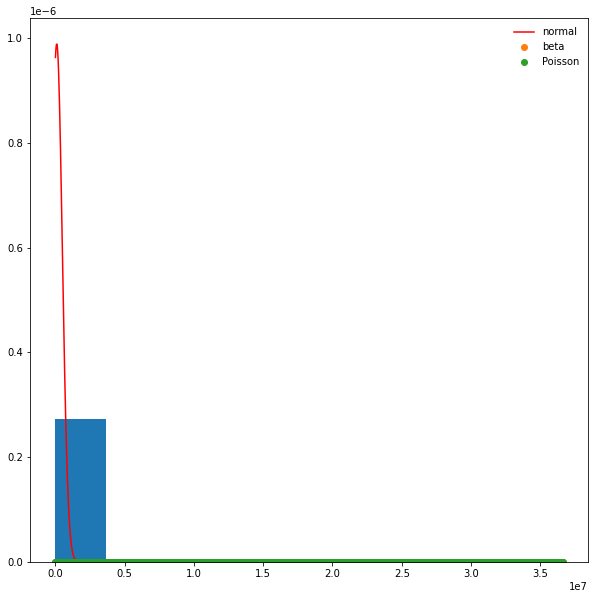

In [ ]:
#fitting distributions

x = np.linspace(data.ValorAnterior.min(),data.ValorAnterior.max(),1000)

fitted_data = scipy.stats.distributions.norm.pdf(x, mean, varianza)
fitted_data_beta = scipy.stats.distributions.beta.pdf(x,0.1, 0.8)
fitted_data_pois = scipy.stats.distributions.poisson.pmf(x,mean)

plt.figure(figsize=(10,10));
plt.hist(variable, density=True,bins=10)
plt.plot(x,fitted_data,'r-',label="normal")
plt.plot(x,fitted_data_beta,'o',label="beta")
plt.plot(x,fitted_data_pois,'o',label="Poisson")
plt.legend(loc='upper right', frameon=False)

## Simulación de Data

In [6]:
## CREACIÓN DE DICCIONARIOS PARA SIMULAR DATA POR EL VALOR ESPERADO POR ESTRATO SOCIOECONÓMICO

data_consumo=data.groupby('Id_SubCategoria').ValorAnterior.agg({'mean','median','min','max','std'})
data_unidades=data.groupby('Id_SubCategoria').UnidadesAnt1.agg({'mean','median','min','max','std'})
index_est=data_consumo.index
dict_consumo=data_consumo.to_dict()
dict_unidades=data_unidades.to_dict()
dict_consumo

{'max': {'1 - ESTRATO 1': 578351.64,
  '11 - 220 Voltios.': 36618865.23,
  '2 - ESTRATO 2': 963315.76,
  '3 - ESTRATO 3': 1137273.12,
  '4 - ESTRATO 4': 4588592.16,
  '5 - ESTRATO 5': 1688764.0},
 'mean': {'1 - ESTRATO 1': 32689.543984962445,
  '11 - 220 Voltios.': 549704.9470642203,
  '2 - ESTRATO 2': 39223.05610315173,
  '3 - ESTRATO 3': 84589.32109803965,
  '4 - ESTRATO 4': 101400.61254577915,
  '5 - ESTRATO 5': 125837.50765625003},
 'median': {'1 - ESTRATO 1': 20675.17,
  '11 - 220 Voltios.': 180110.82,
  '2 - ESTRATO 2': 27657.13,
  '3 - ESTRATO 3': 73473.12,
  '4 - ESTRATO 4': 85704.0,
  '5 - ESTRATO 5': 109573.12},
 'min': {'1 - ESTRATO 1': 0.0,
  '11 - 220 Voltios.': 0.0,
  '2 - ESTRATO 2': -21.33,
  '3 - ESTRATO 3': 0.0,
  '4 - ESTRATO 4': 0.0,
  '5 - ESTRATO 5': 0.0},
 'std': {'1 - ESTRATO 1': 45354.97387833887,
  '11 - 220 Voltios.': 2131191.5776605858,
  '2 - ESTRATO 2': 52182.56315923937,
  '3 - ESTRATO 3': 60908.473752083366,
  '4 - ESTRATO 4': 124655.74650453244,
  '5 - 

## Simulación de la información

La idea es que a partir del comportamiento de la base de CaribeSol,  se construyan simulaciones de comportamiento histórico de consumo, conservando la estructura sociodemográfica.

Dado que no se tienen registros históricos de personas que hayan dejado de pagar sus obligaciones de energía, se asume que los que dejarán de pagar son los que tienen un valor de pago mayor al percentil 75 del último consumo valor del consumo reportado en la base simulada.

In [113]:
from numpy.random import choice

##COSTO POR KWH supuesto para cada estrato
kwh_cost=dict({'1 - ESTRATO 1':[200,1],
               '2 - ESTRATO 2':[200,2],
               '3 - ESTRATO 3':[300,3],
               '4 - ESTRATO 4':[400,4],
               '5 - ESTRATO 5':[500,5],
               '6 - ESTRATO 6':[500,6],
               '11 - 220 Voltios.':[350,7]})

###SIMULACIÓN DE LA DATA:
def simula_cons_energy(N_SAMPLES=10000,p_pago=0.9):
  """N_SAMPLES: número de muestras aleatorias a generar
    p_pago: probabilidad de que las personas paguen su última obligación
  """

  p_pago=0.9
  props_est = data.groupby('Id_SubCategoria')['Id_SubCategoria'].count()/data.shape[0]
  props_loc= data.groupby('Localidad')['Localidad'].count()/data.shape[0]
  LOCALIDAD=choice(props_loc.index.values, N_SAMPLES, p=props_loc.values)
  ESTRATO=choice(props_est.index.values, N_SAMPLES, p=props_est.values)
  UNIDADES=[np.random.default_rng().normal(dict_unidades['mean'][i],dict_unidades['std'][i], 1)[0] for i in ESTRATO]
  med_cal=np.median(UNIDADES)
  print(f"Unidades de Consumo negativas se reemplazarán por {med_cal}")
  UNIDADES=np.where(np.array(UNIDADES)<=0,med_cal,UNIDADES)
  VALOR_CONS=[UNIDADES[i]*kwh_cost[ESTRATO[i]][0] for i in range(N_SAMPLES)]
  VALORDEF=np.quantile(VALOR_CONS,0.75)
  print(f"Considerando No pagos con valores de factura superiores a {VALORDEF}")
  NO_PAGO_ULTIMO=[0 if i<=VALORDEF else 1 for i in VALOR_CONS]
  data_out=pd.DataFrame({'localidad':LOCALIDAD,'estrato':ESTRATO,'valor_ant':VALOR_CONS,'unidades_ant':UNIDADES,'no_pago_ultimo':NO_PAGO_ULTIMO})
  return(data_out)

data_out=simula_cons_energy(10000,0.9)
data_out.head()

Unidades de Consumo negativas se reemplazarán por 311.44580404123866
Considerando No pagos con valores de factura superiores a 146937.76166202073


,localidad,estrato,valor_ant,unidades_ant,no_pago_ultimo
0,MEDELLÍN,2 - ESTRATO 2,14016.000836,70.080004,0
1,MEDELLÍN,3 - ESTRATO 3,53070.067222,176.900224,0
2,MEDELLÍN,2 - ESTRATO 2,140605.209051,703.026045,0
3,MEDELLÍN,2 - ESTRATO 2,44092.128125,220.460641,0
4,MEDELLÍN,2 - ESTRATO 2,80038.243799,400.191219,0


In [115]:
### SIMULAR EL CONSUMO DE LOS ÚLTIMOS 12 MESES

def cons_ultim_12(key_val,base_val):
  values=[]
  values.append(base_val)
  [values.append(np.abs((dict_unidades['std'][key_val]*1.02*choice([-1,1],1,p=[0.5,0.5])[0])+values[i])) for i in range(12)]
  return(values[::-1])
  
unidades_ultim_12=[cons_ultim_12(data_out.estrato.values[i],data_out.unidades_ant.values[i]) for i in range(len(data_out.estrato))];

In [116]:
unidades_ultim_12=np.reshape(unidades_ultim_12,((-1,13)))
unidades_ultim_12=pd.DataFrame(unidades_ultim_12,columns=["mes_t-"+str(12-i) for i in range(13)])
unidades_ultim_12

,mes_t-12,mes_t-11,mes_t-10,mes_t-9,mes_t-8,mes_t-7,mes_t-6,mes_t-5,mes_t-4,mes_t-3,mes_t-2,mes_t-1,mes_t-0
0,977.530364,715.627772,453.725180,715.627772,453.725180,191.822588,70.080004,331.982596,70.080004,331.982596,70.080004,191.822588,70.080004
1,176.900224,308.049417,176.900224,308.049417,439.198610,308.049417,439.198610,308.049417,176.900224,45.751031,176.900224,45.751031,176.900224
2,1226.831229,1488.733821,1226.831229,964.928637,1226.831229,1488.733821,1226.831229,1488.733821,1226.831229,964.928637,703.026045,441.123453,703.026045
3,220.460641,41.441951,303.344543,41.441951,303.344543,565.247135,303.344543,41.441951,303.344543,41.441951,220.460641,41.441951,220.460641
4,2495.411955,2233.509363,2495.411955,2233.509363,1971.606771,1709.704179,1447.801587,1185.898995,1447.801587,1185.898995,923.996403,662.093811,400.191219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,293.575312,162.426119,31.276926,99.872267,31.276926,162.426119,31.276926,162.426119,293.575312,162.426119,31.276926,162.426119,293.575312
9996,910.385196,591.915460,910.385196,591.915460,273.445725,591.915460,273.445725,591.915460,273.445725,45.024011,363.493746,681.963482,363.493746
9997,1886.936177,2338.124634,1886.936177,1435.747720,984.559263,533.370805,82.182348,369.006109,82.182348,369.006109,820.194566,1271.383024,820.194566
9998,1161.489668,899.587076,637.684483,375.781891,113.879299,148.023293,113.879299,148.023293,409.925885,671.828477,409.925885,148.023293,409.925885


## Generando Clustering de Usuarios

GMM (EM Algorithm)


In [21]:
##LIBRARY FOR MCA ANALYSIS
!pip install prince

In [117]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import seaborn as sns
#pip install prince
import prince as pr ##por MCA


## modificar estrato a valor numérico.
data_out['estrato']=data_out['estrato'].apply(lambda x: kwh_cost[x][1])
data_aux=data_out[['estrato','localidad','valor_ant']].copy()
data_aux.valor_ant=[(i-np.min(data_aux.valor_ant))/(np.max(data_aux.valor_ant)-np.min(data_aux.valor_ant)) for i in data_aux.valor_ant]
mca=pr.MCA(n_components=-1).fit_transform(data_aux.values)
gmm = GaussianMixture(n_components=4)
gmm.fit(mca)



GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [118]:
#predictions from gmm
labels = gmm.predict(mca)
mca

,0,1,2,3,4,5,6,7
0,-1.040558,-0.152133,0.797155,0.355735,-1.075237,-0.160481,0.733879,0.402045
1,-0.527511,-0.050120,-0.798328,-0.863049,-0.056832,-0.510321,-0.495030,0.306756
2,-1.026085,-0.159442,0.769412,0.356704,-1.084598,-0.221607,-0.069182,0.055891
3,-1.023528,-0.151525,0.797981,0.331832,-1.100342,-0.160570,-1.163489,0.821836
4,-1.030997,-0.155504,0.795826,0.317543,-1.062400,-0.160459,-0.621003,-0.574100
...,...,...,...,...,...,...,...,...
9995,-0.492242,-0.046042,-0.816140,-0.843481,-0.090510,-0.531235,-0.694407,0.163518
9996,1.755519,0.263193,1.212653,-0.911800,0.040848,0.570220,-0.353671,0.534822
9997,0.542927,-0.459759,-0.590634,1.055764,-0.213742,-0.871223,-0.996302,0.177968
9998,-0.521922,-0.158855,0.763154,0.340297,-0.765022,1.444905,-0.299970,-0.419711


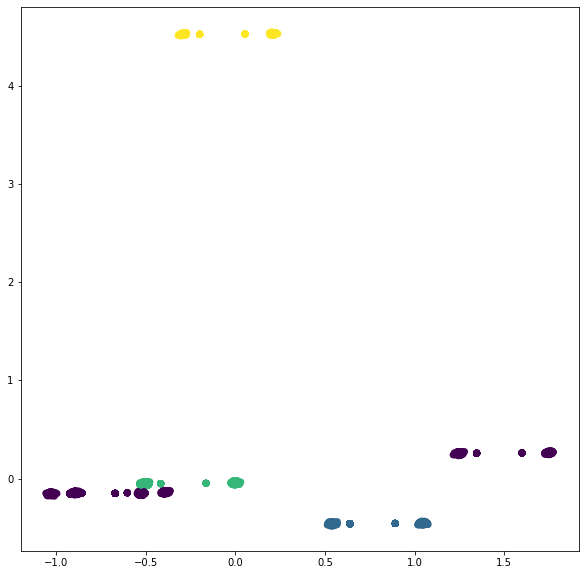

In [119]:
data_clust=pd.DataFrame(mca.values,columns=["dim "+str(i) for i in range(mca.shape[1])])
data_clust['cluster']=labels

f,ax=plt.subplots(figsize=(10,10))
ax.scatter(data_clust['dim 0'],data_clust['dim 1'],c=data_clust['cluster'])



## Modelo Predictivo Pago
## Involucrar fuentes externas : desempleo


In [ ]:
desempleo=pd.read_excel("desempleo.xlsx",skiprows=8)
### get last 36 months 
desempleo=desempleo.iloc[0:36,0:2]
desempleo.head()

,Año(aaaa)-Mes(mm),Tasa de empleo (%)
0,2020-06,46.052214
1,2020-05,43.380810
2,2020-04,41.570360
3,2020-03,51.702287
4,2020-02,55.475531


In [154]:
##reshape data and generate training/test set
from sklearn.metrics import precision_score,recall_score,cohen_kappa_score,f1_score,accuracy_score

### función para medir desempeño

def metrics(real,pred):
  kappa=cohen_kappa_score(real,pred)
  acc=accuracy_score(real,pred)
  f1=f1_score(real,pred)
  prec=precision_score(real,pred)
  recall=recall_score(real,pred)

  print (f" Accuracy:{acc:.4f} \n Precision: {prec:.4f} \n Recall: {recall:.4f} \n Kappa: {kappa:.4f} \n F1-Score: {f1:.4f} ")

##standardize by day (not by column)
def std_day(x,rang=13):
  """x: INPUT AS A NUMPY ARRAY 
    rang: columna hasta la cual de desea estandarizar
  """
  daily_data_Train=x[:,range(rang)].T
  scaled_features =StandardScaler()
  daily_dataSTD_Train=scaled_features.fit_transform(daily_data_Train).T
  return (daily_dataSTD_Train)

#X=X.reshape((-1,13,1))

X=unidades_ultim_12.values

X=std_day(X)
y=data_out.no_pago_ultimo.values


Codificación de variables categóricas

In [121]:
###encode localidad
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
loc_enc=le.fit_transform(data_out.localidad)
data_out.loc[:,'localidad']=loc_enc
data_out.head()

,localidad,estrato,valor_ant,unidades_ant,no_pago_ultimo
0,1,2,14016.000836,70.080004,0
1,1,3,53070.067222,176.900224,0
2,1,2,140605.209051,703.026045,0
3,1,2,44092.128125,220.460641,0
4,1,2,80038.243799,400.191219,0


In [122]:
le.classes_

array(['BELLO', 'MEDELLÍN'], dtype=object)

In [155]:
X2=data_out.drop(columns=["no_pago_ultimo","unidades_ant"]).values
X=np.column_stack((X,X2))

In [124]:
### train & test partition

from sklearn.model_selection import train_test_split
###15% for testing, stratify by Y
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=222,test_size=0.15)

nrows,ncol=X_train.shape


### Modelo:

Esta red neuronal combina ambas fuentes de información (Comportamiento de los consumos de los últimos 12 meses y la información sociodemográfica)

In [125]:
X_train1=X_train[:,range(13)].reshape((-1,13,1))
X_test1=X_test[:,range(13)].reshape((-1,13,1))

X_train2=X_train[:,13::]
X_test2=X_test[:,13::]

In [126]:
print(X_train1.shape,X_train2.shape)

(8500, 13, 1) (8500, 3)


In [127]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM,Dense,Flatten,Input,LeakyReLU,Conv1D,BatchNormalization,Dropout,Concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2,l1

ncol=X_test1.shape[1]


##mod1
lstm_input = Input(shape=(ncol,1), name='encoder_input')
x=LSTM(128,return_sequences=True)(lstm_input)
x=LeakyReLU()(x)
x=BatchNormalization()(x)
x=LSTM(128,return_sequences=True)(x)
x=Dropout(0.3)(x)
x=LSTM(128,return_sequences=False)(x)
x=LeakyReLU()(x)
x=Dropout(0.3)(x)
x=Dense(120)(x)
x=LeakyReLU()(x)
x=Dropout(0.3)(x)
x=Dense(2,activation="linear")(x)
out_layer= Model(lstm_input, x,name="lstm")

##mod2

mlp_input=Input(shape=(3,),name="input_mlp")
x2=Dense(50)(mlp_input)
x2=LeakyReLU()(x2)
x2=BatchNormalization()(x2)
x2=Dense(10,activation="linear")(x2)
x2=Dense(2,activation="linear")(x2)
out_layer2=Model(mlp_input,x2,name="mlp")


combinedInput = Concatenate()([out_layer.output, out_layer2.output])
z = Dense(100, activation="relu")(combinedInput)
z = Dense(2, activation="softmax")(z)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[out_layer.input, out_layer2.input], outputs=z,name="stacking")


##ver resumen modelo
print(out_layer.summary())
print("=======================")
print(out_layer2.summary())
print("=======================")
print(model.summary())

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 13, 1)]           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 13, 128)           66560     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 13, 128)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 128)           512       
_________________________________________________________________
lstm_9 (LSTM)                (None, 13, 128)           131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               131584 

In [128]:
cb_f = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,restore_best_weights=True) #set the best weights found at scoring on validation set
opt = Adam(lr=1e-4)
model.compile(metrics=['accuracy'],loss=tf.keras.losses.binary_crossentropy, optimizer=opt)

print("[INFO] training model...")
model.fit(
	x=[X_train1,X_train2], y=y_train,	validation_data=([X_test1,X_test2], y_test),	epochs=50, batch_size=20,callbacks=[cb_f])


[INFO] training model...
Epoch 1/50
425/425 [==============================] - 25s 59ms/step - loss: 0.6932 - accuracy: 0.5040 - val_loss: 0.6931 - val_accuracy: 0.8947
Epoch 2/50
425/425 [==============================] - 23s 54ms/step - loss: 0.6931 - accuracy: 0.5240 - val_loss: 0.6931 - val_accuracy: 0.3340
Epoch 3/50
425/425 [==============================] - 22s 52ms/step - loss: 0.6931 - accuracy: 0.5068 - val_loss: 0.6931 - val_accuracy: 0.3893
Epoch 4/50
425/425 [==============================] - 25s 59ms/step - loss: 0.6931 - accuracy: 0.4924 - val_loss: 0.6931 - val_accuracy: 0.5327
Epoch 5/50
425/425 [==============================] - 21s 48ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6931 - val_accuracy: 0.5113
Epoch 6/50
425/425 [==============================] - 20s 47ms/step - loss: 0.6931 - accuracy: 0.5102 - val_loss: 0.6931 - val_accuracy: 0.8347
Epoch 7/50
425/425 [==============================] - 22s 53ms/step - loss: 0.6931 - accuracy: 0.5094 - val_los

In [129]:
predic_train=np.argmax(model.predict([X_train1,X_train2]),axis=1)
predic_test=np.argmax(model.predict([X_test1,X_test2]),axis=1)

In [130]:
## El modelo se comporta muy mal (es de esperarse puesto que la asignación de los no pagos fue determinística pero sólo en el último valor de consumo reportado. De seguro si sólo se usa el último valor y la información sociodemográfica, el modelo
##se comportaría mejor, como veremos a continuación) Sin embargo este ejercicio sirve para involucrar diferentes fuentes de datos reales en el futuro.
from collections import Counter
Counter(predic_test)
print("==TRAINING FINAL RESULTS==")
metrics(y_train,predic_train)
print("==TESTING FINAL RESULTS==")
metrics(y_test,predic_test)

==TRAINING FINAL RESULTS==
 Accuracy:0.8846 
 Precision: 0.9991 
 Recall: 0.5388 
 Kappa: 0.6364 
 F1-Score: 0.7001 
==TESTING FINAL RESULTS==
 Accuracy:0.8947 
 Precision: 0.9954 
 Recall: 0.5813 
 Kappa: 0.6739 
 F1-Score: 0.7340 


In [158]:
## Resumen del modelo y guardarlo en formato Tensorflow
model.summary()
model.save("stacking.h5")

Model: "stacking"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 13, 1)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 13, 128)      66560       encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 13, 128)      0           lstm_8[0][0]                     
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 13, 128)      512         leaky_re_lu_9[0][0]              
___________________________________________________________________________________________

In [132]:
## zip file 
!zip "stacking.zip" stacking/*

updating: stacking/assets/ (stored 0%)
updating: stacking/saved_model.pb (deflated 90%)
updating: stacking/variables/ (stored 0%)


In [134]:
#load model
mod_loaded= tf.keras.models.load_model('stacking')
mod_loaded.summary()

Model: "stacking"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 13, 1)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 13, 128)      66560       encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 13, 128)      0           lstm_8[0][0]                     
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 13, 128)      512         leaky_re_lu_9[0][0]              
___________________________________________________________________________________________

In [156]:
##Aplicar modelo para la base de datos simulada en su total

X_1=X[:,range(13)].reshape((-1,13,1))
X_2=X[:,13::]

#estructura de la base de nuevo
print(X_1[0].shape,X_2[0].shape)


(13, 1) (5,)


In [109]:
mod_loaded.summary()

Model: "stacking"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 13, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 13, 128)      66560       encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 13, 128)      0           lstm[0][0]                       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 13, 128)      512         leaky_re_lu[0][0]                
___________________________________________________________________________________________

In [137]:
##exportar a csv
data_out['cluster']=labels ## se añade el cluster obtenido 
#data_out['no_paga_sig_mes']=np.argmax(model.predict([X_1,X_2]),axis=1)
##usar el modelo recién cargado
data_out['no_paga_sig_mes']=np.argmax(mod_loaded.predict([X_1,X_2]),axis=1)
data_out.to_csv("datos_gen.csv",sep=";",decimal=",",index=False)

## Modelo Sencillo

## Forecast de Recaudo a 3 meses

Tendremos que pronosticar a 3 meses el valor de las unidades consumidas. Para 
ello se debe redefinir el problema y la base de entrenamiento


In [148]:
#Retomando lo utilizado en secciones anteriores

#NOTA: tomar en cuenta que en escenario real, la estandarización debe hacerse por individuo, con la base de entrenamiento, y aplicarla por aparte a los datos definidos en la ventana de testeo

Z=unidades_ultim_12.values
Z=std_day(Z)

train=Z[:,range(10)]
test=Z[:,[10,11,12]]

#reshape data
nr,nc=train.shape
train=train.reshape((-1,nc,1))
#test=test.reshape((-1,nc,1))

#como no haremos modelos con diferente output, podemos usar una estructura secuencial en Keras

forec=Sequential(name="forecast_lstm")
forec.add(LSTM(120,input_shape=(nc,1),return_sequences=True))
forec.add(Dropout(0.3))
forec.add(BatchNormalization())
forec.add(LSTM(64,input_shape=(nc,1),return_sequences=False))
forec.add(Dropout(0.3))
forec.add(BatchNormalization())
forec.add(Dense(120))
forec.add(LeakyReLU())
forec.add(Dropout(0.2))
forec.add(Dense(3,activation="linear"))

forec.summary()


Model: "forecast_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 10, 120)           58560     
_________________________________________________________________
dropout_12 (Dropout)         (None, 10, 120)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 10, 120)           480       
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                47360     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dense_23 (Dense)             (None, 120)             

In [66]:
##training
## Se debe comparar con otros métodos de forecasting

from tensorflow.keras.callbacks import EarlyStopping

cb_reg = EarlyStopping(monitor='mse', patience=10,restore_best_weights=True) #set the best weights found at scoring on validation set
opt = Adam(lr=1e-4)
forec.compile(metrics=['mse'],loss='mse', optimizer=opt)

print("[INFO] training model...")
forec.fit(x=train, y=test,epochs=50, batch_size=20,callbacks=[cb_reg])


[INFO] training model...
Epoch 1/50
500/500 [==============================] - 8s 15ms/step - loss: 0.8180 - mse: 0.8180
Epoch 2/50
500/500 [==============================] - 8s 15ms/step - loss: 0.5961 - mse: 0.5961
Epoch 3/50
500/500 [==============================] - 8s 15ms/step - loss: 0.5362 - mse: 0.5362
Epoch 4/50
500/500 [==============================] - 8s 15ms/step - loss: 0.5056 - mse: 0.5056
Epoch 5/50
500/500 [==============================] - 8s 15ms/step - loss: 0.4911 - mse: 0.4911
Epoch 6/50
500/500 [==============================] - 8s 15ms/step - loss: 0.4757 - mse: 0.4757
Epoch 7/50
500/500 [==============================] - 7s 15ms/step - loss: 0.4612 - mse: 0.4612
Epoch 8/50
500/500 [==============================] - 7s 15ms/step - loss: 0.4570 - mse: 0.4570
Epoch 9/50
500/500 [==============================] - 7s 15ms/step - loss: 0.4502 - mse: 0.4502
Epoch 10/50
500/500 [==============================] - 7s 15ms/step - loss: 0.4408 - mse: 0.4408
Epoch 11/50
50

In [159]:
np.mean(np.mean((forec.predict(train)-test)**2,axis=1))
forec.save("forec.h5")
#!zip "forec.zip" forec/*

In [140]:
##load model saved in .pb format
forec_load= tf.keras.models.load_model('forec')

In [151]:
##FORECAST WITH TRAIN DATA
forecast=forec_load.predict(train)

##FORECAST FOR THE NEXT 3 MONTHS
##los últimos 10 meses para hacer forecast en los próximos 3
newdata=(Z[:,3:]).reshape((-1,10,1))
forecast_new=forec_load.predict(newdata)

values=unidades_ultim_12.apply(lambda x: [np.mean(x),np.std(x)],axis=1).to_dict()
##reconstruct original data

forecast_new=[(forecast_new[i]*values[i][1])+values[i][0] for i in range(len(forecast_new))]

In [153]:
forecast_new=pd.DataFrame(np.reshape(forecast_new,(-1,3)),columns=["mes_t-1","mes_t-2","mes_t-3"])
datos_consumo=pd.concat((unidades_ultim_12,forecast_new),axis=1)
datos_consumo.to_csv("consumos.csv",sep=";",decimal=",",index=False)